## CLIK vs Gradient Descent:
This script compares the CLIK-based approach with GD-based approach for numerical IK.

In [3]:
from importnb import Notebook
with Notebook():
    import gradient_descent_2dofs_arm as robot

/home/introduction_to_robotics/lecture3/gradient_descent_2dofs_arm.ipynb:33: SyntaxWarning: invalid escape sequence '\p'
  '''We define a function that computes the end-effector forward kinematics for a 2-DOF planar arm:
/home/introduction_to_robotics/lecture3/gradient_descent_2dofs_arm.ipynb:72: SyntaxWarning: invalid escape sequence '\e'
  '''We define another function that computes the full forward kinematics (in terms of position) for a 2-DOF planar arm:
/home/introduction_to_robotics/lecture3/gradient_descent_2dofs_arm.ipynb:116: SyntaxWarning: invalid escape sequence '\m'
  '''We now define a function to compute the Jacobian matrix $\mathbf{J}(\mathbf{q}) \in \mathbb{R}^{3 \times 2}$ for the 2-DOF planar arm:
/home/introduction_to_robotics/lecture3/gradient_descent_2dofs_arm.ipynb:160: SyntaxWarning: invalid escape sequence '\m'
  '''The following function is the GD loop for the IK.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime
import imageio
from IPython.display import display, clear_output

We define a function for the Closed Loop Inverse Kinematics (CLIK) for a 2-DOF planar arm using differential IK:

$$\mathbf{q}_{i+1} = \mathbf{q}_i + \mathbf{J}(\mathbf{q})^{-1} \mathbf{K} \left( \mathbf{p}_{target} - \mathbf{p} \right)$$

**Parameters:**

$\mathbf{p}_{target}$: $\in \mathbb{R}^{2}$ target to reach
    
$\mathbf{q}_i$: $\in \mathbb{R}^{2}$ initial joint angles in radians.

$control\_idx$: list of indices indicating which dimensions of the end-effector to control (0 for $x$, 1 for $y$, 2 for $\phi$).

$l_1$: float Length of link 1.

$l_2$: float Length of link 2.

$K$: float gain

$tol$: float tolerance for convergence.
    
$max\_iters$: int maximum number of iterations.
    
$visualize$: bool whether to visualize the process.

**Return:**

$\mathbf{q}$, $fk\_ee(q[0], q[1], l_1, l_2)$, $cost$

where $\mathbf{q}$ is the final joint angles, $fk\_ee$ is the final end-effector position, and $cost$ is the final cost.

In [6]:
def clik(
    target,
    initial_q,
    control_idx=[0, 1],
    l1=1.0,
    l2=1.0,
    K=0.1,
    tol=1e-6,
    max_iters=1000,
    visualize=True,
    pause_time=0.01,
):
    log = []

    # -------------------------
    # Input validation
    # -------------------------
    if len(control_idx) != 2:
        raise ValueError("control_idx must have exactly two elements for a 2-DOF arm.")
    if control_idx[0] > control_idx[1]:
        raise ValueError("control_idx must be in ascending order.")
    if control_idx[0] < 0 or control_idx[1] > 2:
        raise ValueError("control_idx values must be in the range [0, 2].")
    if target.shape[0] != 2:
        raise ValueError("target must be a 2D vector.")

    q = np.array(initial_q, dtype=float)

    # -------------------------
    # Visualization setup
    # -------------------------
    if visualize:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-(l1 + l2) - 0.5, (l1 + l2) + 0.5)
        ax.set_ylim(-(l1 + l2) - 0.5, (l1 + l2) + 0.5)
        ax.set_aspect("equal")
        ax.grid(True)

        ax.plot(target[0], target[1], "rx", markersize=10, label="Target")
        line, = ax.plot([], [], "o-", linewidth=3, label="Arm")
        ax.legend()

        frames = []

    # -------------------------
    # Gradient descent loop
    # -------------------------
    for k in range(max_iters):
        current_pos = robot.fk_ee(q[0], q[1], l1, l2)
        error = target - np.array([current_pos[i] for i in control_idx])
        cost = np.linalg.norm(error)

        log.append([q[0], q[1], current_pos[0], current_pos[1], K, cost])

        if cost < tol:
            break

        J = robot.compute_jacobian(q[0], q[1], l1, l2)[control_idx]
        q += np.linalg.inv(J) @ (K * error)

        # -------------------------
        # Real-time animation (Jupyter)
        # -------------------------
        if visualize:
            x1, y1, x2, y2 = robot.full_fk(q[0], q[1], l1, l2)
            line.set_data([0, x1, x2], [0, y1, y2])
            ax.set_title(f"Iteration {k}, cost = {cost:.3e}")

            clear_output(wait=True)
            display(fig)

            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            frame = frame[:, :, 1:4]  # ARGB → RGB
            frames.append(frame)

            plt.pause(pause_time)

    # -------------------------
    # Save log
    # -------------------------
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_file = f"clik_2dofs_arm_log_{timestamp}.csv"

    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["q0", "q1", "x", "y", "K", "cost"])
        writer.writerows(log)

    print(f"Saved joint values to {log_file}")

    # -------------------------
    # Save GIF
    # -------------------------
    if visualize and len(frames) > 0:
        gif_name = f"clik_2dofs_arm_{timestamp}.gif"
        imageio.mimsave(gif_name, frames, fps=int(1 / pause_time))
        print(f"Saved GIF: {gif_name}")

    return q, robot.fk_ee(q[0], q[1], l1, l2), cost

For the comparison, we first run the *CLIK* numerical method, and consecutively *GD* method.

# CLIK

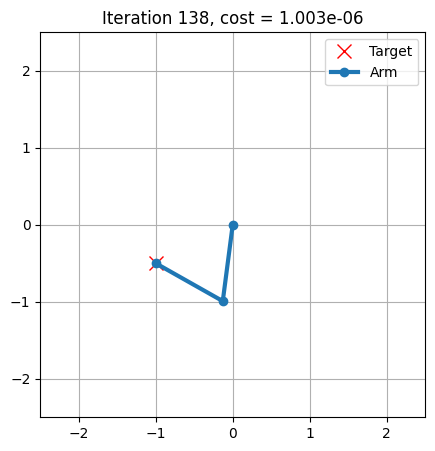

Saved joint values to clik_2dofs_arm_log_2025-12-27_15-03-23.csv
Saved GIF: clik_2dofs_arm_2025-12-27_15-03-23.gif
----CLIK RESULTS----
Final joint angles: [-1.7003476  -1.95519402]
Final end-effector position: [-0.9999991  -0.50000009 -3.65554163]
Final cost: 9.024064273686973e-07


In [7]:
if __name__ == "__main__":
    target = np.array([-1., -0.5])
    initial_q = np.array([.0, -np.pi/2.])
    final_q, final_pos, final_cost = clik(target, initial_q, K=0.1)
    print("----CLIK RESULTS----")
    print(f"Final joint angles: {final_q}")
    print(f"Final end-effector position: {final_pos}")
    print(f"Final cost: {final_cost}")

# Gradient Descent

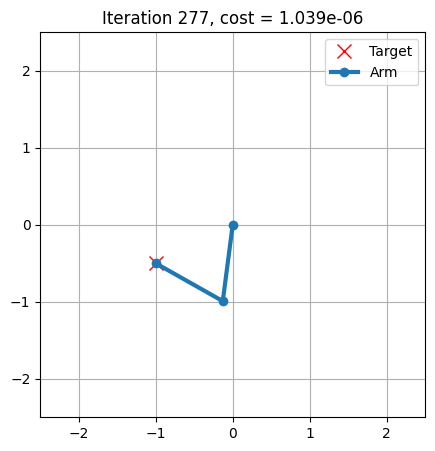

Saved joint values to gradient_descent_2dofs_arm_log_2025-12-27_15-03-56.csv
Saved GIF: gd_2dofs_arm_2025-12-27_15-03-56.gif
----GRADIENT DESCENT RESULTS----
Final joint angles: [-1.7003476 -1.9551942]
Final end-effector position: [-0.99999901 -0.49999994 -3.65554179]
Final cost: 9.883439774269545e-07


In [8]:
    final_q, final_pos, final_cost = robot.gradient_descent_ik(target, initial_q, sigma=0.1)
    print("----GRADIENT DESCENT RESULTS----")
    print(f"Final joint angles: {final_q}")
    print(f"Final end-effector position: {final_pos}")
    print(f"Final cost: {final_cost}")

# Plot results

In [9]:
import plots_2dofs_arm

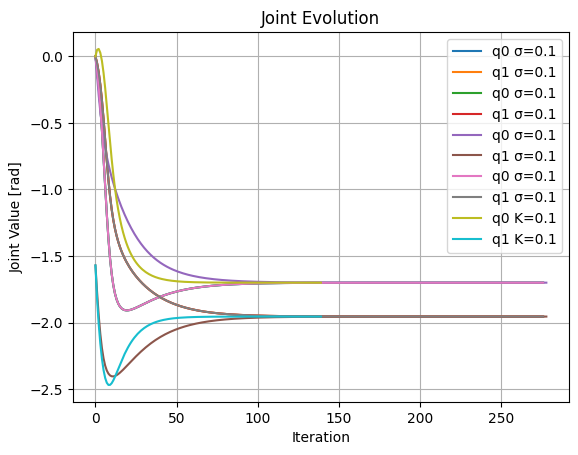

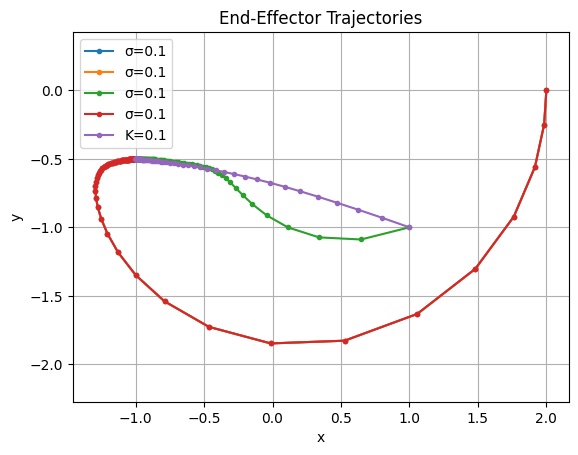

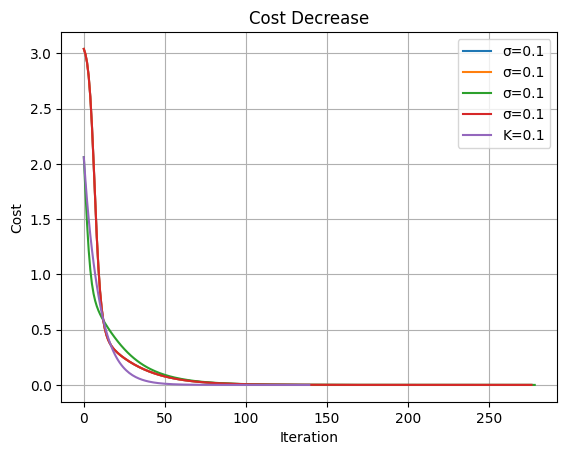

In [10]:
if __name__ == "__main__":
    plots_2dofs_arm.main()